In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
import string
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re


In [ ]:
import nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

[nltk_data] Downloading package stopwords to /home/automl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/automl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
train_df = pd.read_csv("medical_tc_train.csv")
test_df = pd.read_csv("medical_tc_test.csv")
labels_df = pd.read_csv("medical_tc_labels.csv")

In [ ]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower() 
    text = re.sub(r'\@\w+|\#', '', text) # Remove mentions and hashtags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    return text

In [5]:
train_df['cleaned_abstract'] = train_df['medical_abstract'].apply(clean_text)

In [6]:
stop_words = set(stopwords.words('english'))

In [7]:
def get_tokens(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

In [8]:
def get_ngrams(text, n):
    tokens = get_tokens(text)
    n_grams = list(ngrams(tokens, n))
    return [" ".join(gram) for gram in n_grams]

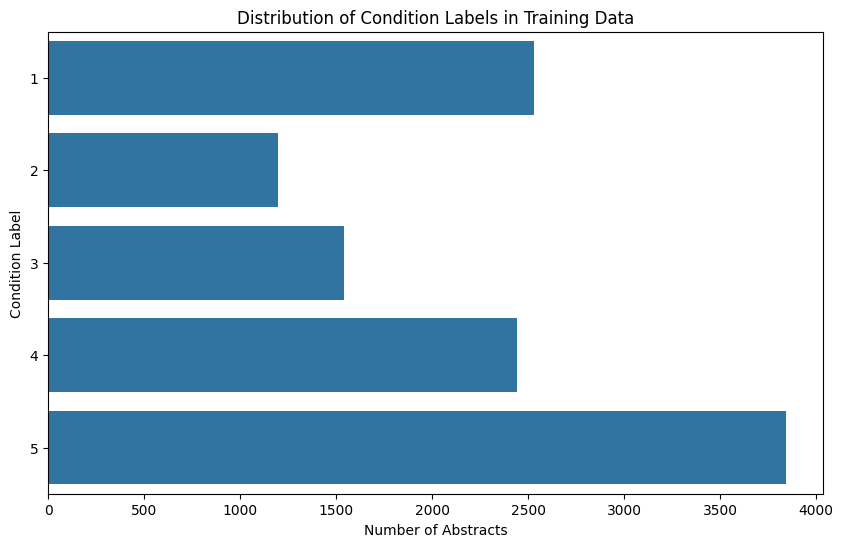

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, y='condition_label')
plt.title('Distribution of Condition Labels in Training Data')
plt.xlabel('Number of Abstracts')
plt.ylabel('Condition Label')
plt.show()


In [10]:
train_df['abstract_length'] = train_df['medical_abstract'].astype(str).apply(len)

In [12]:
grouped_abstracts_train = train_df.groupby('condition_label')['cleaned_abstract'].apply(lambda x: " ".join(x))

In [13]:
def get_word_frequencies(text):
    if not text:
        return Counter()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()] 
    return Counter(tokens)


In [14]:
analytic_vectorizer = TfidfVectorizer(
    max_features=10000, 
    stop_words='english' 
)


In [15]:
tfidf_matrix = analytic_vectorizer.fit_transform(train_df['cleaned_abstract'])
feature_names = analytic_vectorizer.get_feature_names_out() 

In [17]:
# Calculate sparsity
density = tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])
sparsity = 1 - density

print(f"\nMatrix shape: {tfidf_matrix.shape}")
print(f"Number of non-zero elements: {tfidf_matrix.nnz}")
print(f"Density: {density:.6f}")
print(f"Sparsity: {sparsity:.6f} ({sparsity*100:.2f}% of elements are zero)")

# Memory usage
sparse_size = tfidf_matrix.data.nbytes + tfidf_matrix.indptr.nbytes + tfidf_matrix.indices.nbytes
dense_size = tfidf_matrix.shape[0] * tfidf_matrix.shape[1] * 8  # 8 bytes per float64

print(f"\nMemory usage:")
print(f"Sparse matrix: {sparse_size / 1024**2:.2f} MB")
print(f"Equivalent dense matrix would use: {dense_size / 1024**2:.2f} MB")
print(f"Memory saved: {(dense_size - sparse_size) / 1024**2:.2f} MB")


Matrix shape: (11550, 10000)
Number of non-zero elements: 690832
Density: 0.005981
Sparsity: 0.994019 (99.40% of elements are zero)

Memory usage:
Sparse matrix: 7.95 MB
Equivalent dense matrix would use: 881.20 MB
Memory saved: 873.25 MB


In [20]:
label_map = {i: f"Label {i}" for i in sorted(train_df['condition_label'].unique())}

In [21]:
label_map

{np.int64(1): 'Label 1',
 np.int64(2): 'Label 2',
 np.int64(3): 'Label 3',
 np.int64(4): 'Label 4',
 np.int64(5): 'Label 5'}

In [17]:
average_tfidf_per_class = {}
for label in sorted(train_df['condition_label'].unique()):
    indices = train_df.index[train_df['condition_label'] == label].tolist()
    # Get the sub-matrix for this label's documents
    tfidf_subset = tfidf_matrix[indices, :]
    avg_scores = tfidf_subset.mean(axis=0).A1 # .A1 converts sparse matrix result to a numpy array
    average_tfidf_per_class[label] = dict(zip(feature_names, avg_scores))

In [18]:
num_top_discriminative_words = 15 

In [19]:

for label, avg_scores_dict in average_tfidf_per_class.items():
    sorted_words = sorted(avg_scores_dict.items(), key=lambda item: item[1], reverse=True)
    top_words = sorted_words[:num_top_discriminative_words]

    print(f"\n--- Label {label} ({label_map.get(label, 'Unknown Label')}) ---")
    if top_words:
        for word, score in top_words:
            print(f"  {word}: {score:.4f}")


--- Label 1 (Label 1) ---
  patients: 0.0451
  cancer: 0.0378
  tumor: 0.0337
  carcinoma: 0.0306
  cell: 0.0271
  cells: 0.0266
  tumors: 0.0260
  cases: 0.0186
  survival: 0.0175
  breast: 0.0174
  treatment: 0.0169
  disease: 0.0150
  malignant: 0.0147
  chemotherapy: 0.0142
  human: 0.0140

--- Label 2 (Label 2) ---
  patients: 0.0525
  disease: 0.0256
  liver: 0.0235
  hepatitis: 0.0182
  gastric: 0.0179
  esophageal: 0.0156
  biliary: 0.0155
  bowel: 0.0153
  treatment: 0.0152
  hepatic: 0.0148
  ulcer: 0.0147
  patient: 0.0146
  group: 0.0142
  cirrhosis: 0.0140
  gallbladder: 0.0131

--- Label 3 (Label 3) ---
  patients: 0.0429
  pain: 0.0198
  cerebral: 0.0179
  syndrome: 0.0174
  brain: 0.0172
  disease: 0.0152
  stroke: 0.0144
  nerve: 0.0141
  treatment: 0.0137
  group: 0.0128
  clinical: 0.0127
  patient: 0.0126
  spinal: 0.0119
  case: 0.0115
  seizures: 0.0113

--- Label 4 (Label 4) ---
  patients: 0.0487
  coronary: 0.0343
  ventricular: 0.0272
  pressure: 0.0266
  art

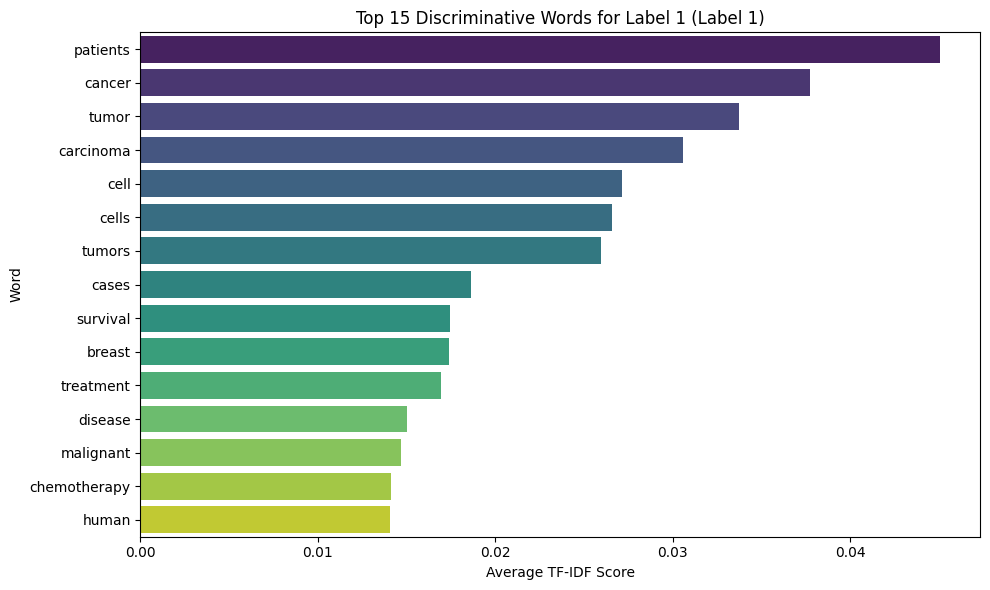

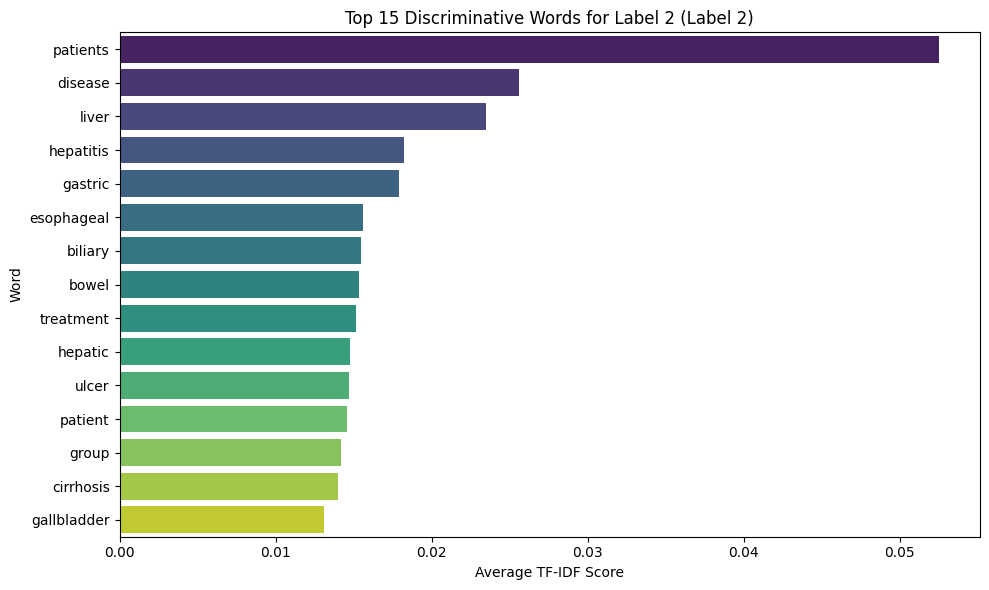

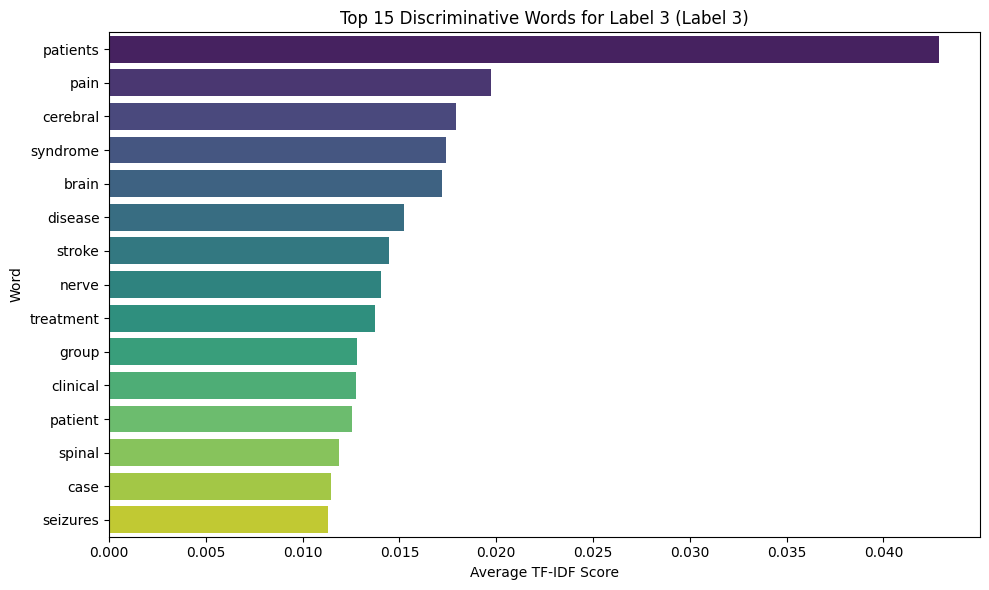

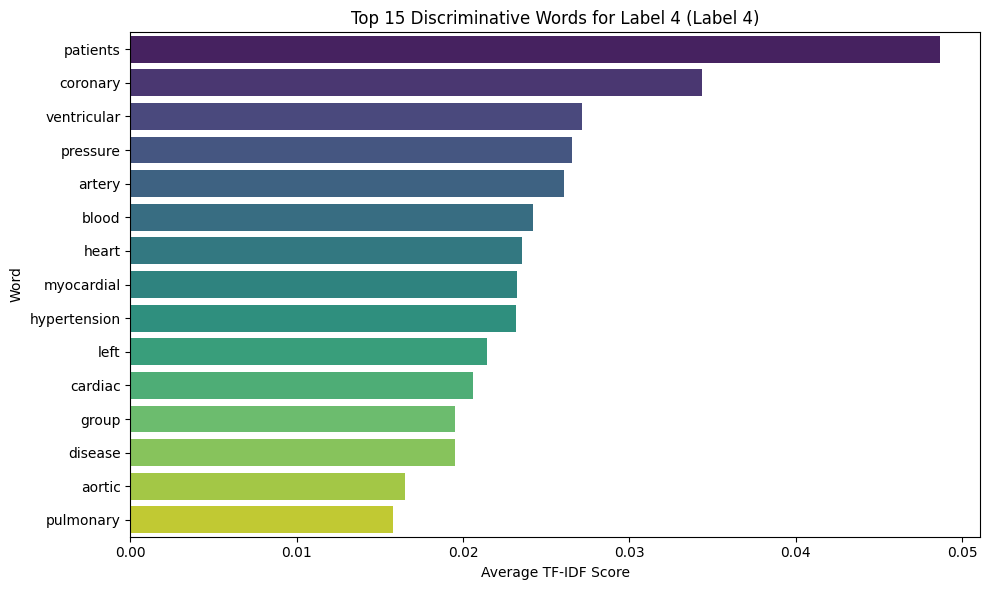

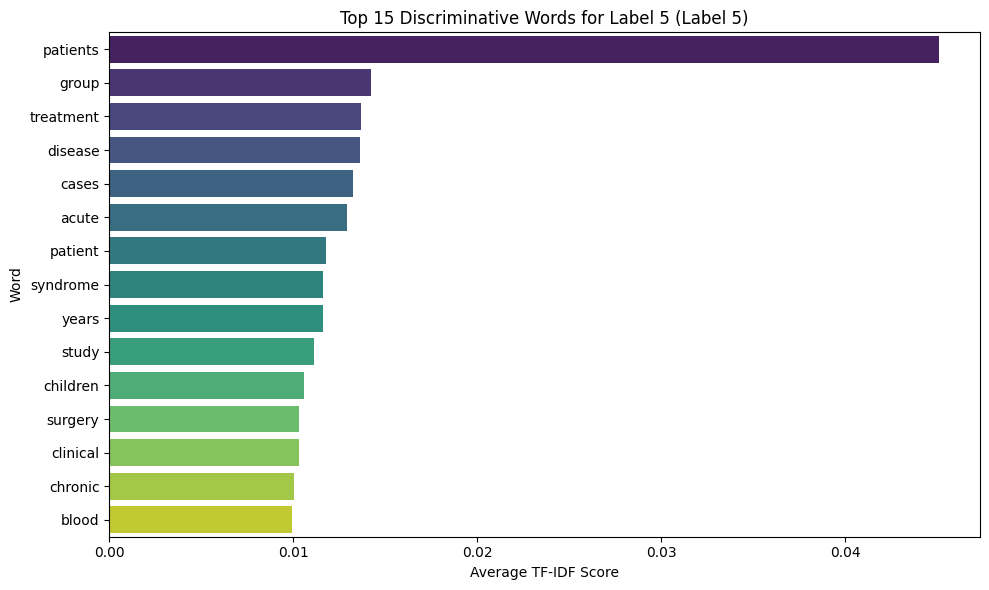

In [20]:
if average_tfidf_per_class:
    sorted_labels = sorted(average_tfidf_per_class.keys())

    for label in sorted_labels:
        avg_scores_dict = average_tfidf_per_class[label]

       
        # Sort words by their average TF-IDF score and get the top N
        sorted_words = sorted(avg_scores_dict.items(), key=lambda item: item[1], reverse=True)
        top_words_plot = sorted_words[:num_top_discriminative_words]

        if top_words_plot:
            words, scores = zip(*top_words_plot)

            # Create a NEW figure and axis for each label's plot
            # Adjust figsize based on the number of words to prevent labels overlapping
            fig, ax = plt.subplots(figsize=(10, max(5, len(words) * 0.4))) # Dynamic height


            sns.barplot(x=list(scores), y=list(words),hue=list(words), palette='viridis', ax=ax, legend=False)

            label_name = label_map.get(label, f'Label {label}')
            ax.set_title(f'Top {num_top_discriminative_words} Discriminative Words for Label {label} ({label_name})')

            # Set axis labels
            ax.set_xlabel('Average TF-IDF Score')
            ax.set_ylabel('Word')

            plt.tight_layout()

            plt.show()


Analyzing N-grams for Condition Label: 1 (Training Data)
Top 20 Bigrams for Label 1 (Train Data):


/tmp/ipykernel_1791912/479962978.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='Blues_d')


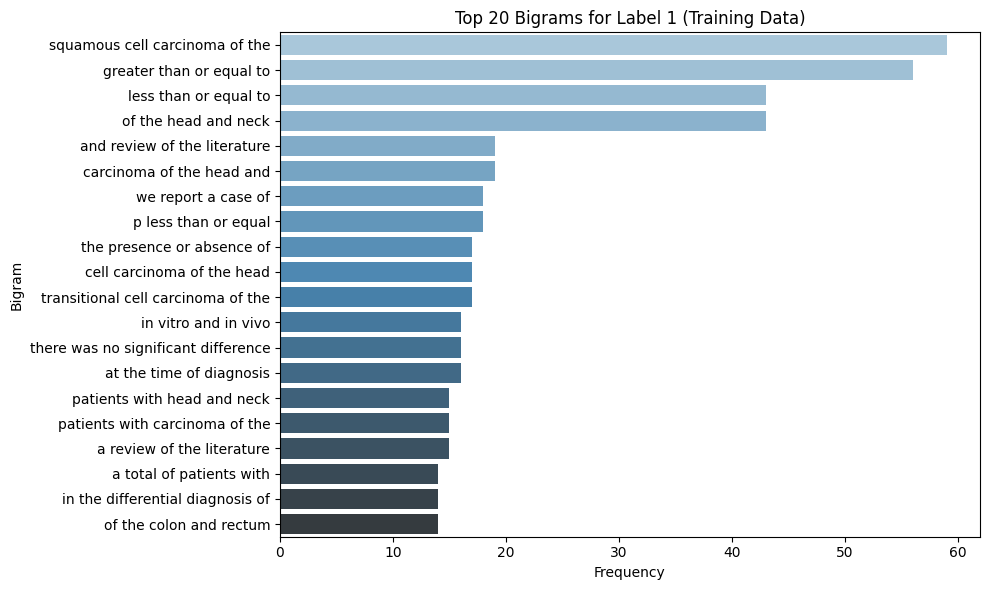

Top 20 Trigrams for Label 1 (Train Data):


/tmp/ipykernel_1791912/479962978.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='Greens_d')


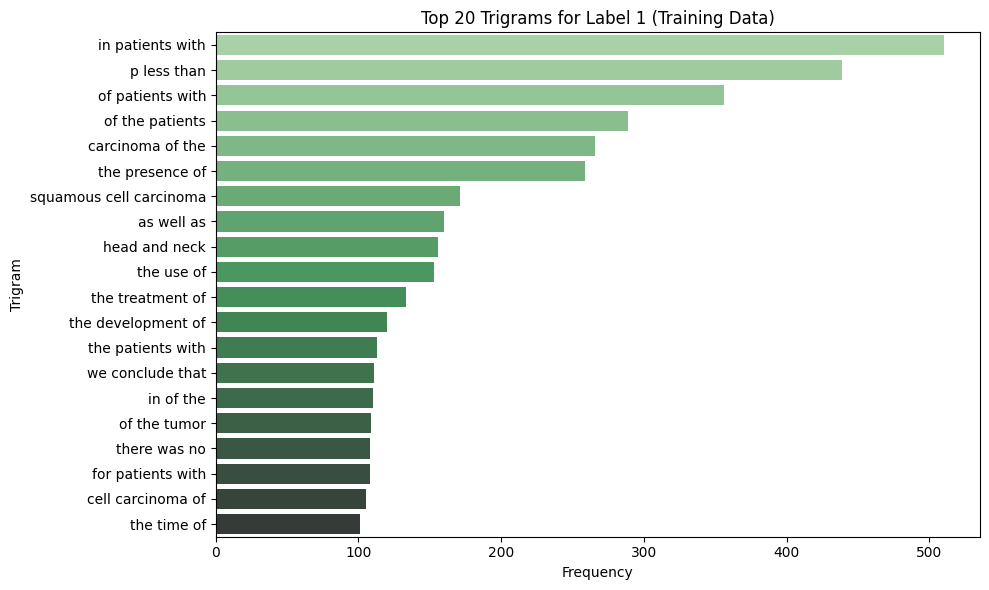


Analyzing N-grams for Condition Label: 2 (Training Data)
Top 20 Bigrams for Label 2 (Train Data):


/tmp/ipykernel_1791912/479962978.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='Blues_d')


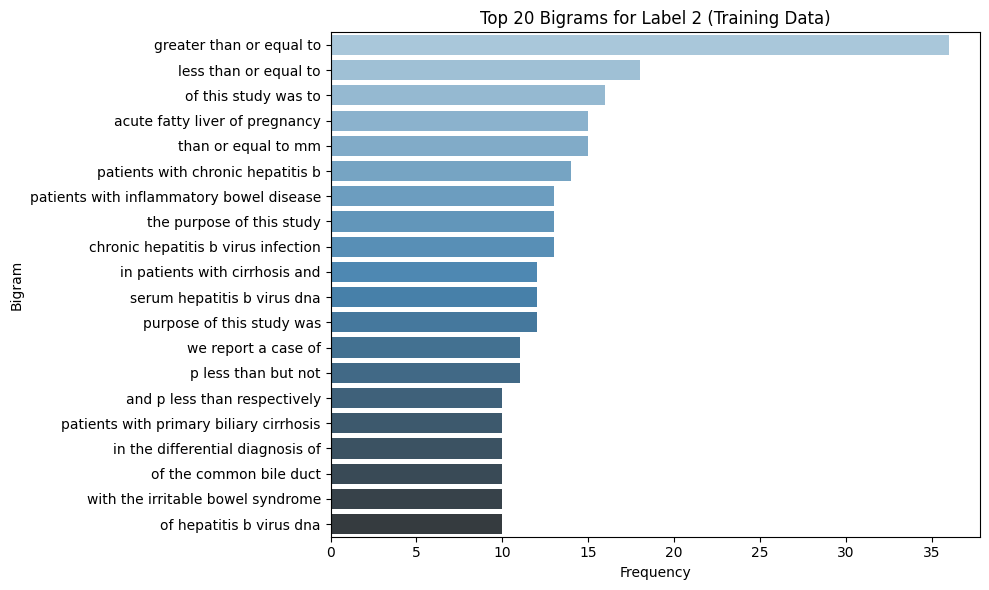

Top 20 Trigrams for Label 2 (Train Data):


/tmp/ipykernel_1791912/479962978.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='Greens_d')


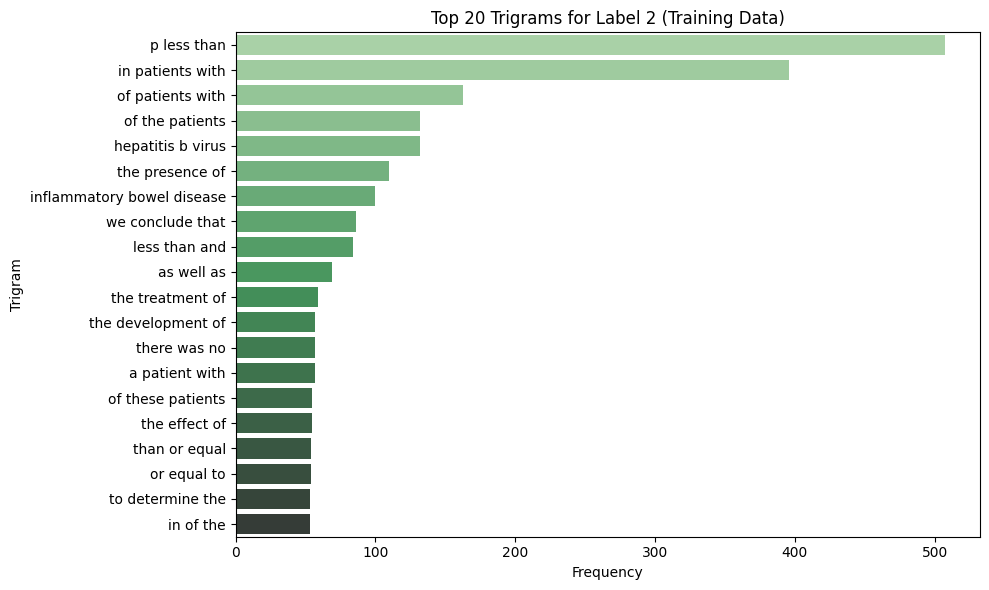


Analyzing N-grams for Condition Label: 3 (Training Data)
Top 20 Bigrams for Label 3 (Train Data):


/tmp/ipykernel_1791912/479962978.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='Blues_d')


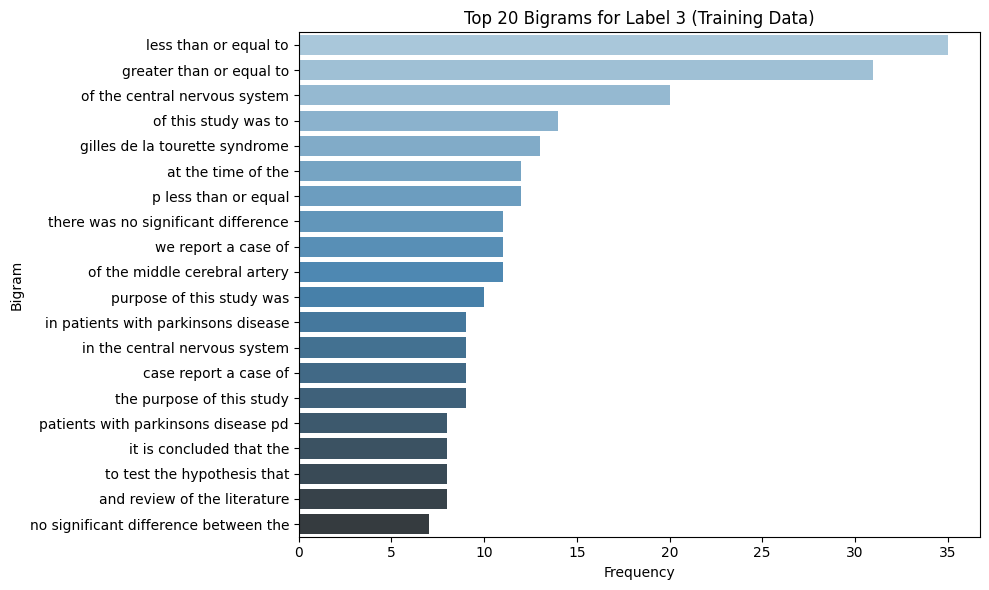

Top 20 Trigrams for Label 3 (Train Data):


/tmp/ipykernel_1791912/479962978.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='Greens_d')


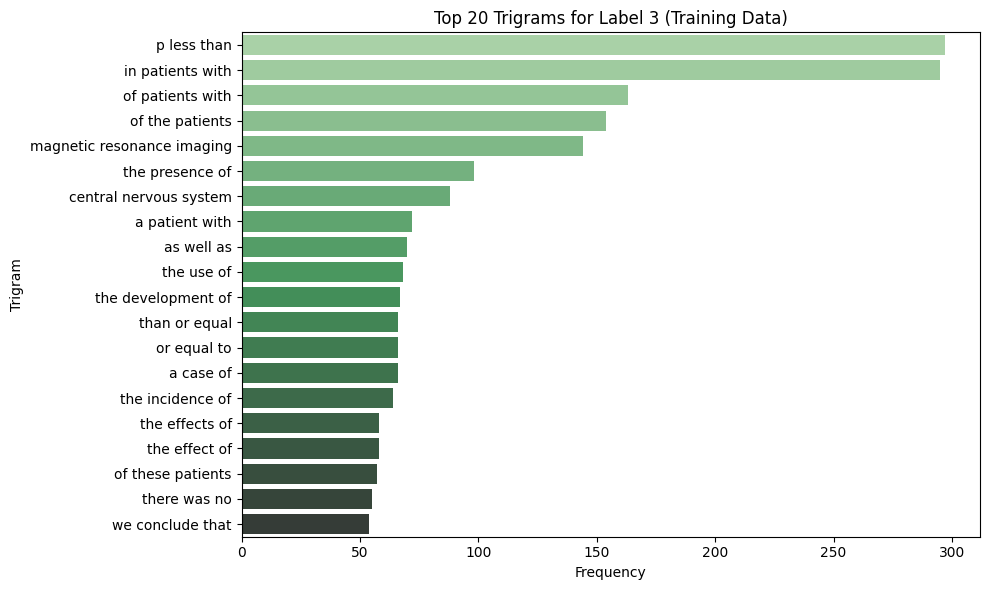


Analyzing N-grams for Condition Label: 4 (Training Data)
Top 20 Bigrams for Label 4 (Train Data):


/tmp/ipykernel_1791912/479962978.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='Blues_d')


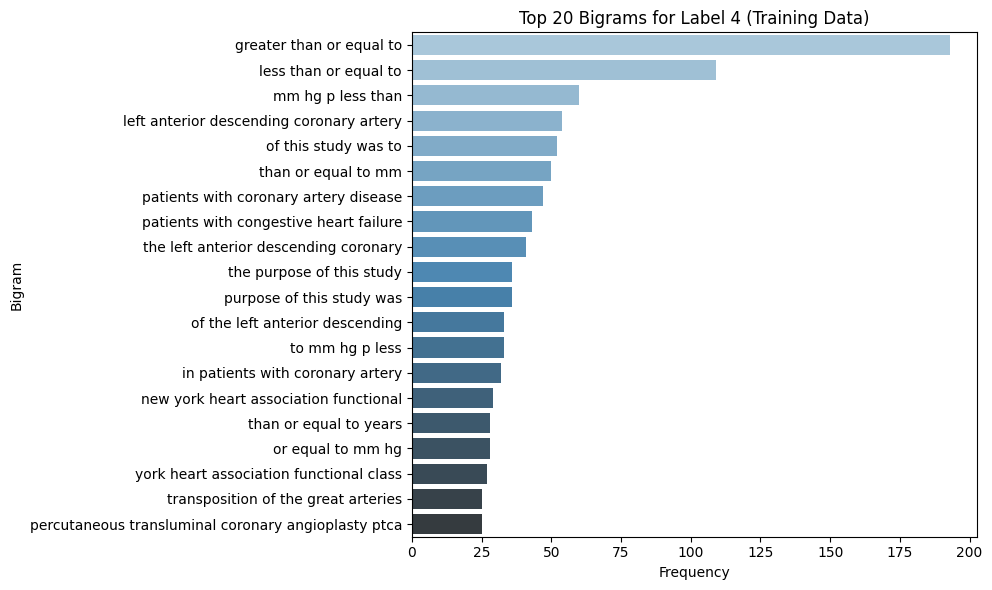

Top 20 Trigrams for Label 4 (Train Data):


/tmp/ipykernel_1791912/479962978.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='Greens_d')


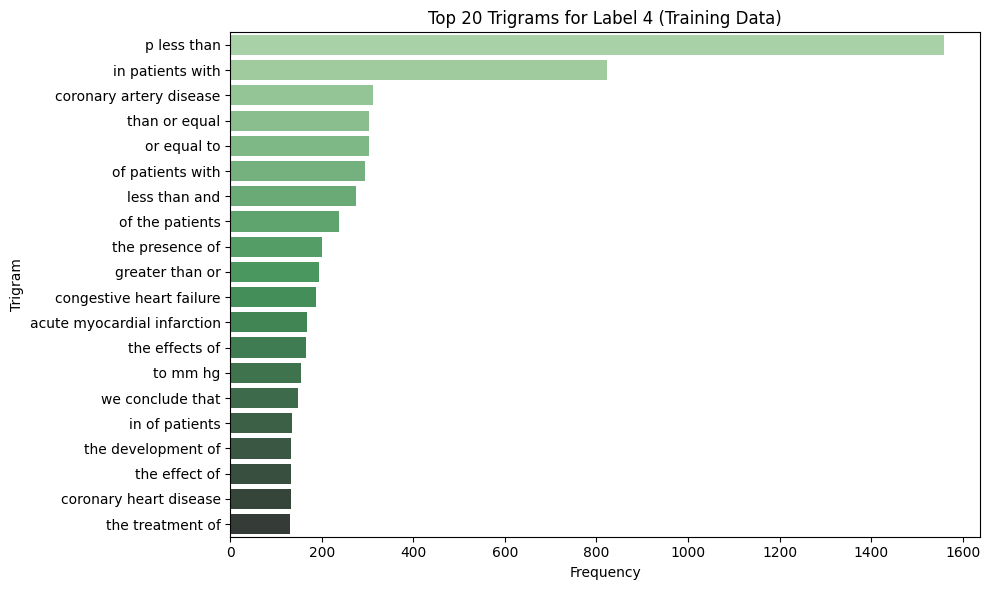


Analyzing N-grams for Condition Label: 5 (Training Data)
Top 20 Bigrams for Label 5 (Train Data):


/tmp/ipykernel_1791912/479962978.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='Blues_d')


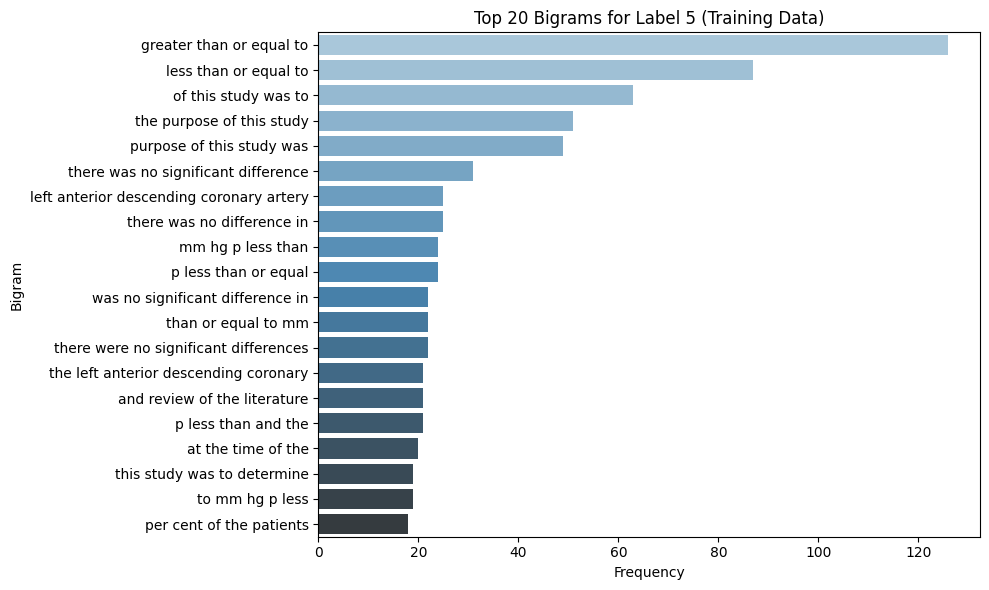

Top 20 Trigrams for Label 5 (Train Data):


/tmp/ipykernel_1791912/479962978.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='Greens_d')


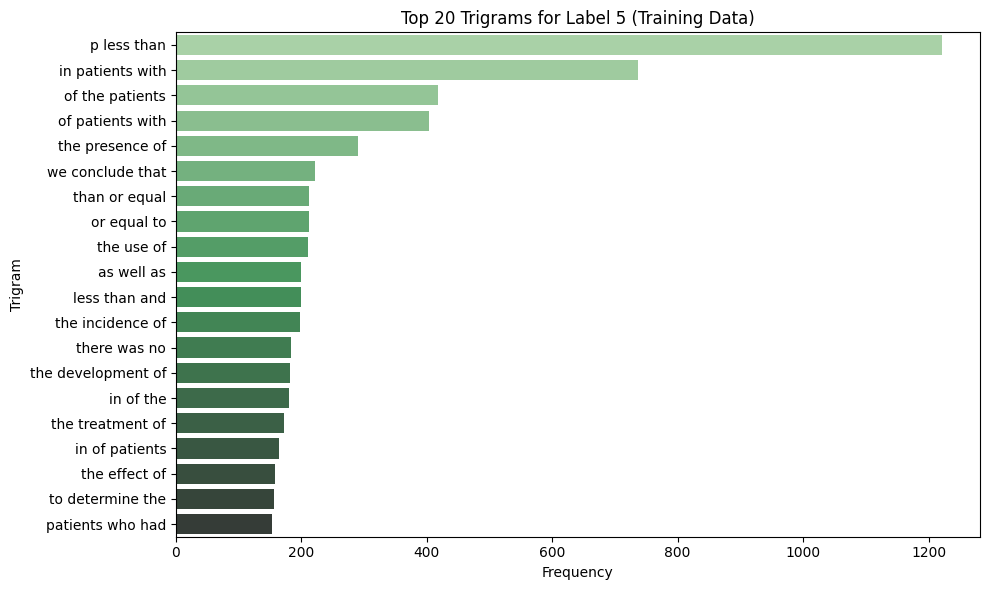

In [ ]:
num_top_ngrams = 20

def simple_tokenize(text):
    # Lowercase, remove punctuation, and split by whitespace
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    return text.split()

def get_ngrams_simple(text, n):
    tokens = simple_tokenize(text)
    n_grams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(gram) for gram in n_grams]

for label, text in grouped_abstracts_train.items():
    print(f"\nAnalyzing N-grams for Condition Label: {label} (Training Data)")

    # Get Bigrams
    bigrams = get_ngrams_simple(text, 5)
    bigram_counts = Counter(bigrams)
    top_bigrams = bigram_counts.most_common(num_top_ngrams)

    if top_bigrams:
        print(f"Top {num_top_ngrams} Bigrams for Label {label} (Train Data):")
        words, counts = zip(*top_bigrams)
        plt.figure(figsize=(10, min(6, len(words) * 0.5)))
        sns.barplot(x=list(counts), y=list(words), hue=list(words), palette='Blues_d', legend=False)
        plt.title(f'Top {num_top_ngrams} Bigrams for Label {label} (Training Data)')
        plt.xlabel('Frequency')
        plt.ylabel('Bigram')
        plt.tight_layout()
        plt.show()

    # Get Trigrams
    trigrams = get_ngrams_simple(text, 3)
    trigram_counts = Counter(trigrams)
    top_trigrams = trigram_counts.most_common(num_top_ngrams)

    if top_trigrams:
        print(f"Top {num_top_ngrams} Trigrams for Label {label} (Train Data):")
        words, counts = zip(*top_trigrams)
        plt.figure(figsize=(10, min(6, len(words) * 0.5)))
        sns.barplot(x=list(counts), y=list(words),  hue=list(words), palette='Blues_d', legend=False)
        plt.title(f'Top {num_top_ngrams} Trigrams for Label {label} (Training Data)')
        plt.xlabel('Frequency')
        plt.ylabel('Trigram')
        plt.tight_layout()
        plt.show()
    else:
        print(f"No trigrams found for label {label} (Train Data).")

[nltk_data] Downloading package punkt to venv/bin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
